In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import mean_absolute_error,mean_squared_error
import warnings
warnings.filterwarnings("ignore")

data_df = pd.read_csv('dataset/dye.csv',index_col=0)
print (data_df.shape)

y = data_df["Em"]
X = data_df.drop(columns=["Em"])

(396, 899)


In [2]:
#construct RF and SHAP
model = RandomForestRegressor(n_estimators = 50)
model.fit(X,y)
explainer = shap.TreeExplainer(model)
shap_value = explainer.shap_values(X)

In [34]:
#prepare visualization

from IPython import display
from rdkit import Chem
from rdkit.Chem import AllChem, rdDepictor
from IPython.display import SVG
from matplotlib.colors import ColorConverter
import rdkit.Chem.Draw.rdMolDraw2D as mdraw
from rdkit.Chem.Draw import MolDrawing, DrawingOptions, rdMolDraw2D
import matplotlib
import matplotlib.cm as cm

def getSubstructDepiction(mol,atomID,radius):
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
        atomsToUse = list(set(atomsToUse))  #atom list OK    
    else:
        atomsToUse = [atomID]
        env=None
    return (atomsToUse)

idx = 10
shap_output = pd.DataFrame(shap_value[idx,:])
shap_output.index = X.columns

#find structures
mol = Chem.MolFromSmiles(X.index[idx])

#find atom list
atom_score = [0]*mol.GetNumAtoms()
info={}
fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,1024,bitInfo=info)
for key in info:
    bit_name = 'Bit {}'.format(key)
    if bit_name in shap_output.index:
        score = shap_output.loc[bit_name].values[0]
        for atomID,radius in info[key]:
            for i in getSubstructDepiction(mol,atomID,radius):
                atom_score[i] += score

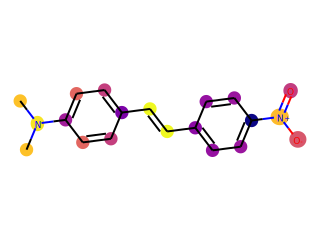

In [35]:
#color ver
smax = np.max(list(map(abs,atom_score))) # absolute maximum value
atom_score = atom_score/smax 
atom_id = [a for a in range(mol.GetNumAtoms())]

molSize=(320, 240)

min_pred = np.amin(atom_score)
max_pred = np.amax(atom_score)

norm = matplotlib.colors.Normalize(vmin=min_pred,vmax=max_pred)
cmap = cm.get_cmap('plasma')
plt_colors = cm.ScalarMappable(norm=norm,cmap=cmap)

atom_colors = {}
for i,atom in enumerate(atom_id):
    color_rgba = plt_colors.to_rgba(atom_score[i])
    atom_rgb = color_rgba #(color_rgba[0],color_rgba[1],color_rgba[2])
    atom_colors[atom] = atom_rgb

rdDepictor.Compute2DCoords(mol)

drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
#drawer.DrawMolecule(mc)
drawer.DrawMolecule(mol,highlightAtoms=atom_id,highlightBonds=[],
    highlightAtomColors=atom_colors)

drawer.FinishDrawing()
svg = drawer.GetDrawingText()
SVG(svg)

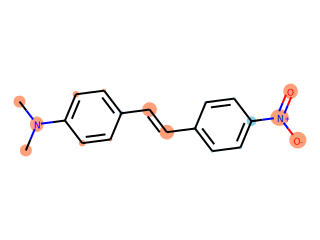

In [36]:
#circle ver.
color_red = ColorConverter().to_rgb('lightsalmon')
color_blu = ColorConverter().to_rgb('skyblue')

atom_id = []
atom_color = {}
atom_radii = {}
for aa in range(mol.GetNumAtoms()): # red is 
    atom_id.append(aa)
    if(atom_score[aa] < 0):
        atom_color[aa] = color_blu
        atom_radii[aa] = float(-atom_score[aa]/3)
    else:
        atom_color[aa] = color_red
        atom_radii[aa] = float(atom_score[aa]/3)

view = mdraw.MolDraw2DSVG(320, 240)
option = view.drawOptions()
option.circleAtoms = True
option.continuousHighlight = True

view.DrawMolecule(mol,
                  highlightAtoms=atom_id,
                  highlightAtomColors=atom_color,
                  highlightAtomRadii=atom_radii,
                  highlightBonds=[],)
view.FinishDrawing()

svg = view.GetDrawingText()
SVG(svg)